### CCTS 40500: FINAL
#### Abdallah Aboelela

In [3]:
# General
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, RepeatVector, Lambda
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import backend as K
from keras import objectives

# Sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Distances
import jellyfish as jf

Using TensorFlow backend.


## Outline
1. Cleaning data/preparing it into a format for our purposes
2. Using Random Forest/a Keras Neural Net based classifier to predict types using existing data
3. Creating a single-layer simple autoencoder to generate new data and testing the new data using exact matches, matplotlib, and Jaro-Winkler string scores (as a replacement for BLAST)
4. ATTEMPT at step 3 for Sequence to Sequence and Variational Autoencoder

#### Cleaning

In [4]:
# setup
seed = 1234
files = ['hiv-db-LTNP.seq', 'hiv-db-SP.seq', 'hiv-db-zRP.seq']

In [5]:
# load dataset
combined = pd.DataFrame()
for fname in files:
    df = pd.read_csv('data/' + fname, header = None)
    df['type'] = fname
    combined = pd.concat([combined, df])
    
combined = combined.replace('hiv-db-LTNP.seq', 'LTNP')
combined = combined.replace('hiv-db-zRP.seq', 'RP')
combined = combined.replace('hiv-db-SP.seq', 'SP')

combined.columns = ['seq', 'type']
combined['len'] = combined.seq.apply(len)

In [6]:
for i in range(max(combined.len)):
    combined[i] = combined.seq.apply(lambda x: get_position(x, i))
    
combined = combined.drop(['seq', 'len'], axis = 1)

In [7]:
combined.head()

,type,0,1,2,3,4,5,6,7,8,...,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839
0,LTNP,A,A,G,C,G,A,A,A,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LTNP,C,C,C,G,A,A,C,A,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LTNP,A,A,A,C,C,A,G,A,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LTNP,A,C,A,G,G,G,A,C,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LTNP,T,G,A,A,A,A,C,A,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
combined = combined.replace(['A', 'T', 'G', 'C', np.nan], list(range(5))).reset_index(drop = True)

#### Attempt using random forest

In [9]:
rf_clf = RandomForestClassifier(n_estimators = 50)
kfold = KFold(n_splits=10, shuffle=True, random_state = seed)
results = cross_val_score(rf_clf, combined.drop('type', axis = 1), combined.type, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 77.86% (11.83%)


#### Attempt at Neural Net

In [10]:
k_clf = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(k_clf, combined.drop('type', axis = 1), combined.type, cv=kfold, error_score = 'raise')
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Baseline: 49.84% (13.81%)


### Creating a single
##### I tried a multi-layer autoencoder and it performed much worse using all these "tests" to see whether the newly generated sequences are appropriate so I'll be sticking with the signle layer model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(combined.drop('type', axis = 1), 
                                                    combined.type, random_state=seed)

In [12]:
input_img = Input(shape=(9840,))
encoded = Dense(4920, activation='relu')(input_img)
decoded = Dense(9840, activation='sigmoid')(encoded)
single_autoencoder = Model(input_img, decoded)

In [13]:
single_autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [14]:
single_autoencoder.fit(X_train, X_train,
                       epochs=25,
                       batch_size=256,
                       shuffle=True,
                       validation_data=(X_test, X_test))

Train on 101 samples, validate on 34 samples
Epoch 1/25
101/101 [==============================] - 7s 69ms/step - loss: 132142.7188 - val_loss: 154240.5625
Epoch 2/25
101/101 [==============================] - 2s 22ms/step - loss: 155731.3125 - val_loss: 144075.1094
Epoch 3/25
101/101 [==============================] - 2s 20ms/step - loss: 145585.0938 - val_loss: 134648.0781
Epoch 4/25
101/101 [==============================] - 2s 20ms/step - loss: 136429.1250 - val_loss: 128462.9844
Epoch 5/25
101/101 [==============================] - 2s 20ms/step - loss: 130291.4062 - val_loss: 127608.8125
Epoch 6/25
101/101 [==============================] - 2s 19ms/step - loss: 129482.2969 - val_loss: 127628.5625
Epoch 7/25
101/101 [==============================] - 2s 18ms/step - loss: 129498.2109 - val_loss: 127557.2656
Epoch 8/25
101/101 [==============================] - 2s 17ms/step - loss: 129372.8438 - val_loss: 127440.0312
Epoch 9/25
101/101 [==============================] - 2s 16ms/step 

In [15]:
decoded_imgs = pd.DataFrame(single_autoencoder.predict(X_test) * 5 // 1) # generating and cleaning

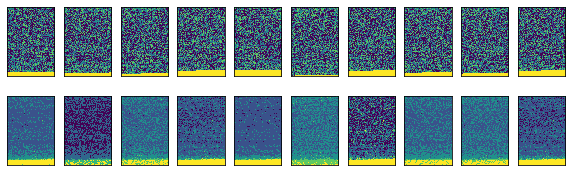

In [16]:
n = 10
plt.figure(figsize=(10, 3))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.array(X_test.iloc[i]).reshape(120, 82))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.array(decoded_imgs.iloc[i]).reshape(120, 82))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##### They look fairly similar, and it seems that the model is able to caputre the missing bottoms fairly well. Though maybe not the overall structure of the genotypes.

#### Next, we look at the proportion of nucleotides that are captured exactly using our autencoder. Furthermore, how well do our random forest and keras classifiers do at classifiying these? (A similar number to above would indicate that the training data is similar to the newly generated data




In [17]:
# Check what appropriate props would be for real data
combos = [('LTNP', 'LTNP'), ('LTNP', 'RP'), ('LTNP', 'SP'), ('RP', 'RP'), ('RP', 'SP'), ('SP', 'SP')]
for pheno1, pheno2 in combos:
    pheno_props = []
    for main_row in combined[combined.type == pheno1].iterrows():
        for check_row in combined[combined.type == pheno2].iterrows():
            pheno_props.append(np.array(main_row[1] == check_row[1]).mean())

    print(pheno1 + '/' + pheno2 + ': ' + str(np.array(pheno_props).mean()))

LTNP/LTNP: 0.3264196840881121
LTNP/RP: 0.3068776440134988
LTNP/SP: 0.29707447514580937
RP/RP: 0.4145130567716443
RP/SP: 0.3152387542292291
SP/SP: 0.35074121185728174


In [18]:
# Proportion of nucleotides identical in decoded (newly generated) and existing sequences
decoded_imgs.index = X_test.index
(decoded_imgs == X_test).mean(axis = 1)

32     0.276016
63     0.252541
68     0.258740
94     0.326321
66     0.295325
6      0.235061
78     0.527439
29     0.255996
62     0.256911
85     0.331504
125    0.692480
89     0.373272
91     0.379167
95     0.286687
40     0.287805
108    0.680996
83     0.282622
102    0.297764
54     0.615955
99     0.316565
98     0.296951
42     0.280386
35     0.248171
8      0.246341
52     0.619817
24     0.239024
22     0.304776
86     0.503252
36     0.593191
27     0.239126
77     0.265752
51     0.618394
48     0.288415
101    0.525203
dtype: float64

##### As expected, these aren't very helpful. Next, we attempt to use our classifiers, and then Jaro-Winkler distance (as a replacement for BLAST/Needleman-Wunsch which I couldn't figure out how to use in Python

I think that Jaro-Winkler distance (or even better, Levanshtein distance on a computer with more resources) would work in a similar fashion to Needleman-Wunsch because it's a measure of string edits

In [21]:
# Fitting on real data and predicting on generated data
rf_clf.fit(combined.drop('type', axis = 1), combined.type)
print(rf_clf.score(decoded_imgs, y_test))
k_clf.fit(combined.drop('type', axis = 1), combined.type)
print(k_clf.score(decoded_imgs, y_test))

0.5588235294117647
0.4411764762857381


##### The keras classifier does about a little better than chance, whereas the Random Forest classifier does a little worse than twice as well as chance (though still not as well as it did on the original data). However, it does much better than expected. Next, I try Jaro-Winkler distance, which is a measure of string edit distance (computationally more efficient than Levenshtein - which would be better in this case)

For reference, 0 represents two completely dissimilar strings and 1 represents identical strings.
The documentation is here: https://jellyfish.readthedocs.io/en/latest/comparison.html#levenshtein-distance

In [22]:
# Check what appropriate props would be for real data
combos = [('LTNP', 'LTNP'), ('LTNP', 'RP'), ('LTNP', 'SP'), ('RP', 'RP'), ('RP', 'SP'), ('SP', 'SP')]
for pheno1, pheno2 in combos:
    pheno_dists = []
    for main_row in combined[combined.type == pheno1].iterrows():
        for check_row in combined[combined.type == pheno2].iterrows():
            s1 = ''.join(list(main_row[1][1:].astype(str)))
            s2 = ''.join(list(check_row[1][1:].astype(str)))
            
            # distance = jf.levenshtein_distance(s1, s2) too computationally expensive unfortunately
            distance = jf.jaro_winkler(s1, s2)
            
            pheno_dists.append(distance)
                                                              
    print(pheno1 + '/' + pheno2 + ': ' + str(np.array(pheno_dists).mean()))

LTNP/LTNP: 0.863679862281599
LTNP/RP: 0.8658040331100316
LTNP/SP: 0.8609120758600326
RP/RP: 0.896430380390975
RP/SP: 0.8714834479158465
SP/SP: 0.8741838985250104


##### These results are very interesting to me, because they indicate that genotypes associated with phenotypes SP and RP have higher JW similarity scores with genotypes within their phenotype group, BUT that LTNP with either of the other two are very similar to LTNP within group which is very surprising. Next I'll run the generated data against the true data

Though I wasn't able to get S2SAE or VAE working, I think that using JW or Levanshtein distances would be a great way to test whether a newly generated sequence would be appropriate becasue it captures how similar the structures are in a way that isn't possible with the exact proportions method used above. Ideally, a newly generated genotype sequence would have similar JW distances to the real genotypes in its phenotype group

In [23]:
JWcombined = pd.concat([y_test, decoded_imgs], axis = 1)

In [24]:
for pheno1 in np.unique(combined.type):
    for pheno2 in np.unique(JWcombined.type):
        pheno_dists = []
        for main_row in combined[combined.type == pheno1].iterrows():
            for check_row in JWcombined[JWcombined.type == pheno2].iterrows():
                s1 = ''.join(list(main_row[1][1:].astype(str)))
                s2 = ''.join(list(check_row[1][1:].astype(str)))

                # distance = jf.levenshtein_distance(s1, s2) too computationally expensive unfortunately
                distance = jf.jaro_winkler(s1, s2)

                pheno_dists.append(distance)

        print('REAL ' + pheno1 + '/ GENERATED ' + pheno2 + ': ' + str(np.array(pheno_dists).mean()))

REAL LTNP/ GENERATED LTNP: 0.5552477448279938
REAL LTNP/ GENERATED RP: 0.5331116596794909
REAL LTNP/ GENERATED SP: 0.5466371317856555
REAL RP/ GENERATED LTNP: 0.5544136368699204
REAL RP/ GENERATED RP: 0.5339053977270792
REAL RP/ GENERATED SP: 0.5451711334414552
REAL SP/ GENERATED LTNP: 0.5572422205137306
REAL SP/ GENERATED RP: 0.5347960874790691
REAL SP/ GENERATED SP: 0.5487197987367439


##### It's clear that the generated distances do failry poorly and are very distant from the real data as compared to the real data against itself.

## WORKING CODE ENDS HERE (EXCEPT APPENDIX)

### Attempt at VAE

In [25]:
X_train, X_test, y_train, y_test = train_test_split(combined.drop('type', axis = 1), 
                                                    combined.type, random_state=seed, test_size = 0.4)

In [26]:
batch_size = 27
original_dim = 9840
intermediate_dim = 9840
latent_dim = 2460
epochs = 25

In [27]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [28]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [29]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [30]:
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [37]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [38]:
vae.fit(X_train, X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test))

Train on 81 samples, validate on 54 samples
Epoch 1/25
81/81 [==============================] - 30s 366ms/step - loss: nan - val_loss: nan
Epoch 2/25
81/81 [==============================] - 18s 222ms/step - loss: nan - val_loss: nan
Epoch 3/25
81/81 [==============================] - 16s 204ms/step - loss: nan - val_loss: nan
Epoch 4/25
81/81 [==============================] - 18s 228ms/step - loss: nan - val_loss: nan
Epoch 5/25
81/81 [==============================] - 20s 245ms/step - loss: nan - val_loss: nan
Epoch 6/25
81/81 [==============================] - 18s 227ms/step - loss: nan - val_loss: nan
Epoch 7/25
81/81 [==============================] - 26s 316ms/step - loss: nan - val_loss: nan
Epoch 8/25
81/81 [==============================] - 23s 285ms/step - loss: nan - val_loss: nan
Epoch 9/25
81/81 [==============================] - 30s 371ms/step - loss: nan - val_loss: nan
Epoch 10/25
81/81 [==============================] - 23s 289ms/step - loss: nan - val_loss: nan
Epoch

In [39]:
# Why are all the losses nan???
decoded_imgs = pd.DataFrame(vae.predict(X_test, batch_size = batch_size))
vae_decoded = pd.concat([y_test, decoded_imgs], axis = 1)

In [40]:
decoded_imgs

,0,1,2,3,4,5,6,7,8,9,...,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


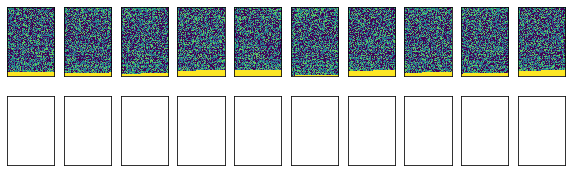

In [41]:
n = 10
plt.figure(figsize=(10, 3))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.array(X_test.iloc[i]).reshape(120, 82))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.array(decoded_imgs.iloc[i]).reshape(120, 82))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
for pheno1 in np.unique(combined.type):
    for pheno2 in np.unique(vae_decoded.type):
        pheno_dists = []
        for main_row in combined[combined.type == pheno1].iterrows():
            for check_row in vae_decoded[vae_decoded.type == pheno2].iterrows():
                s1 = ''.join(list(main_row[1][1:].astype(str)))
                s2 = ''.join(list(check_row[1][1:].astype(str)))

                # distance = jf.levenshtein_distance(s1, s2) too computationally expensive unfortunately
                distance = jf.jaro_winkler(s1, s2)

                pheno_dists.append(distance)

        print('REAL ' + pheno1 + '/ GENERATED ' + pheno2 + ': ' + str(np.array(pheno_dists).mean()))

### Attempt at Sequence to Sequence AE
#### Below is my attempt at a Sequence to Sequence autoencoder, which I had hoped would capture the structure of the data better. Unfortunately, I wasn't able to get it to work but I've kept in the steps I would have liked to take to check how well it did

In [ ]:
timesteps = 9840
input_dim = 1
latent_dim = 4920

In [ ]:
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

In [ ]:
sequence_autoencoder = Model(inputs, decoded)
sequence_autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
sequence_autoencoder.fit(X_train, X_train,
                       epochs=25,
                       batch_size=256,
                       shuffle=True,
                       validation_data=(X_test, X_test))

In [ ]:
decoded_imgs = pd.DataFrame(sequence_autoencoder.predict(X_test))
s2sdecoded = pd.concat([y_test, decoded_imgs], axis = 1)

In [ ]:
for pheno1 in np.unique(combined.type):
    for pheno2 in np.unique(s2sdecoded.type):
        pheno_dists = []
        for main_row in combined[combined.type == pheno1].iterrows():
            for check_row in s2sdecoded[s2sdecoded.type == pheno2].iterrows():
                s1 = ''.join(list(main_row[1][1:].astype(str)))
                s2 = ''.join(list(check_row[1][1:].astype(str)))

                # distance = jf.levenshtein_distance(s1, s2) too computationally expensive unfortunately
                distance = jf.jaro_winkler(s1, s2)

                pheno_dists.append(distance)

        print('REAL ' + pheno1 + '/ GENERATED ' + pheno2 + ': ' + str(np.array(pheno_dists).mean()))

## Appendix

In [1]:
def get_position(x, i):
    try:
        return x[i]
        
    except Exception as e:
        return np.nan

In [2]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=9840, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model